In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# necessary modules -------------------------------------------------------------------------------------
import pyfesom2 as pf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib 
import time
import os
from netCDF4 import Dataset
from scipy.interpolate import griddata
fontsize=24
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize)

In [15]:
# After changing these parameters here, save the notebook and clear the output. 
# Then run this cell and the cells with the desired parameters.

# run specification -------------------------------------------------------------------------------------   
runid    =  'fesom'
meshpath = '/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
alpha, beta, gamma=[0, 0, 0]

simulation_list_short = ['A','B','C','D']
#simulation_list_short = ['A']

#runname='A'
#resultpath12 ='/work/ollie/ogurses/output_f2r2/fesom2.1_recom_New_Initial_Conditions/'+runname+'/'
resultpath ='/work/ollie/ogurses/output_f2r2/fesom2.1_recom_New_Initial_Conditions/'


# period of analysis 
first_year = 2020 #1959
last_year  = 2021
years = range(first_year, last_year+1) # annual
records=len(years)*12 # monthly

# folder for netcdf file
save_dir = '/work/ollie/ogurses/GCB2022/test'

# specifics for netcdf file names
model_id = 'FESOM2_REcoM'
grid_id  = '1_gr' # 1_gr for CORE, 2_gr for BOLD
time_range = str(first_year)+'-'+str(last_year)+'_v20220716'
vers = '_v20220716'
# simulation_id & variable_id are defined in loop further down

In [4]:
# Define variable name and attributes

# List of variables
variable_list1_2D = ['fgco2',\
                     'sfco2',\
                     'fice',\
                     'tos',\
                     'sos',\
                     'dissicos',\
                     'talkos',\
                     'intdic',\
                     'pCO2s',\
                    ] # variable_id will be defined in loop

# corresponding units (according to GCB2022 protocol; model output is converted where necessary)
units_list1_2D   = ['mol C m-2 s-1',\
                    'mu atm',\
                    'n.d.',\
                    'degC',\
                    'g kg-1',\
                    'mol C m-3',\
                    'mol C m-3',\
                    'mol C m-2',\
                    'uatm',\
                   ]
descr_list1_2D   = ['Flux density of the total air-sea CO2 exchange (positive downward)',\
                    'Surface ocean CO2 fugacity (fCO2)',\
                    'fractional ice-cover (=sea-ice concentration) used for the computation of the air-sea exchange flux [0-1]',\
                    'sea-surface temp',\
                    'sea-surface salinity',\
                    'sea-surface DIC',\
                    'sea-surface alkalinity',\
                    'Vertically-integrated DIC',\
                    'Partial pressure of oceanic CO2',\
                   ]

# List of variables -------------------------------------------------------------------------------------
# for a single variable
if True:
    variable_list1_2D = ['pCO2s'] # variable_id will be defined in loop
    # corresponding units (according to GCB2022 protocol; model output is converted where necessary)
    units_list1_2D    = ['uatm']
    descr_list1_2D    = ['Partial pressure of oceanic CO2']

In [5]:
# define time range -> convert specified years to "seconds since start year"

eval_time = np.arange(first_year,last_year+1)
tsteps = (last_year+1-first_year)*12 

# convert to RECCAP format: time since Jan 1, 1980 (or as coded here: since specified start year)
# assume: time in the middle of the month!
# for GCB2022 years or months are enough

sec_in_year = 86400*365
sec_in_year_leap = 86400*366
sec_in_day = 86400

leap_years = [1960,1964,1968,1972,1976,1980,1984,1988,1992,1996,2000,2004,2008,2012,2016,2020]
reccap_time = np.zeros(tsteps)
seconds_passed = 0
for yy in range(0,len(eval_time)):
    if yy==0:
        ind_start = 0
        ind_end   = 12
    else:
        ind_start = 12*yy
        ind_end   = 12*yy+12
    if eval_time[yy] in leap_years:
        mid_month = [15.5,28,31,30,31,30,31,31,30,31,30,31] 
        mid_month = np.cumsum(mid_month)
    else:
        mid_month = [15.5,29,31,30,31,30,31,31,30,31,30,31] 
        mid_month = np.cumsum(mid_month)
    mid_month = mid_month*sec_in_day + seconds_passed
    # keep track of total seconds passed since start year
    if eval_time[yy] in leap_years:
        seconds_passed = seconds_passed + sec_in_year_leap 
    else:
        seconds_passed = seconds_passed + sec_in_year
    reccap_time[ind_start:ind_end] = mid_month
    del ind_start,ind_end,mid_month
del sec_in_year,sec_in_year_leap,sec_in_day,leap_years,seconds_passed

In [16]:
# mesh initialization 

# load fesom mesh (CORE, fesom2)
mesh_id_src    = 'fesom2_core_288'      
mesh = pf.load_mesh(meshpath)

# load mesh properties from mesh output file (CORE, fesom2)
meshdiag = '/work/ollie/ogurses/output_f2r2/fesom2.1_recom_New_Initial_Conditions/A/fesom.mesh.diag.nc'

file_area = Dataset(meshdiag)
el_area =file_area.variables['elem_area'][:]
nlevels =file_area.variables['nlevels'][:]-1
el_nodes=file_area.variables['elements'][:,:]-1
nodes_x =file_area.variables['nodes'][0,:]*180./np.pi
nodes_y =file_area.variables['nodes'][1,:]*180./np.pi

# depth of levels 
level_depths = -mesh.zlev[:-1] # 
      
# load FESOM diag 
diag = pf.get_meshdiag(mesh,meshdiag=meshdiag)   
nod_area = diag.nod_area

# nodal area
#nod_area = diag.rename_dims({"nl": "nz1", "nod_n": "nod2"}).nod_area
nod_area.load()
nod_area = np.swapaxes(np.array(nod_area.data),0,1)

# level depth  
# c.f. Danilov et al. (2017)
# "in the vertical direction, the horizontal velocities and scalars are located at mid-levels" 
#layer_depths = -diag['Z'].values # depth of layers
layer_depths =-diag.nz1 # depth of layers
layer_depths = layer_depths[:-1] # lowest depth seems to be benthic?!

# --> layer thickness
delta_z = np.abs(np.diff(mesh.zlev))
delta_aux = np.tile(delta_z,(126858,1))

#print(mesh.zlev)
print(delta_z)

/work/ollie/projects/clidyn/FESOM2/meshes/core2/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /work/ollie/projects/clidyn/FESOM2/meshes/core2/pickle_mesh_py3_fesom2
[  5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  10.  15.  20.  25.
  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 170.
 200. 220. 230. 250. 250. 250. 250. 250. 250. 250. 250. 250. 250. 250.
 250. 250. 250. 350. 250.]


In [7]:
# Functions

def transform_lon_coord(data):
    # change lon coordinate in 2D array from 0-360 to -180:180
    # for 2D arrays: assume lon coordinate to be the 2nd dimension  
    if len(data.shape)==2:
        data_transformed          = np.empty_like(data)
        #data_transformed[0:180,:] = data[180:,:]
        #data_transformed[180:,:]  = data[0:180,:] 
        data_transformed[:,0:180] = data[:,180:]
        data_transformed[:,180:]  = data[:,0:180]   
    elif len(data.shape)==1:
        data_transformed          = np.empty_like(data)
        data_transformed[0:180] = data[180:]
        data_transformed[180:]  = data[0:180]
    return data_transformed

def load_regrid_2D_field_monthly(path,model_id,simulation_id_long,eval_time,\
                                 mesh,X360,Y180,var_name):
    # load monthly data for each year, interpolate to regular grid
    print ('load variable '+var_name+' from FESOM-REcoM output')
    
    
    # define field in which final arary is stored (-> saved to netcdf later)
    data_reg = np.zeros([X360.shape[0],X360.shape[1],len(eval_time)*12])# monthly data are loaded & stored
    if var_name in ['zeu','PAR']:
        zeu_threshold = 0.01
        print ('Extract model depth layer at which PAR is first <= '+str(100*zeu_threshold)+'% of surface PAR')
    else:
        counter = 0 # counter to store time index to write into in "data_reg"
        for yy in range(0,len(eval_time)): 
            print ('Process variable '+var_name+', year '+str(eval_time[yy])+'...')
            
            file1 = path+var_name+'.'+\
                            model_id+'.'+str(eval_time[yy])+'.nc'
            
            ff = Dataset(file1)
            data = ff.variables[var_name][:]  # 12 x mesh.n2d
            # interpolate to regular grid and store in array "data_int"
            for mm in range(0,12): # regrid each month
                # sth goes wrong in regridding (with lon>180)
                #data_int = griddata((mesh.x2, mesh.y2),data[mm,:].ravel(),\
                #    (X360.ravel(), Y180.ravel()), method='nearest')  # Final interpolated field
                #data_reg[:,:,counter] = data_int.reshape((X360.shape[0],X360.shape[1])) 

                # transform lon & data before regridding, transform back afterwards 
                data_to_regrid = data[mm,:]
                data_int = griddata((mesh.x2, mesh.y2),data_to_regrid.ravel(),\
                    (X360_transf.ravel(), Y180_transf.ravel()), method='linear')  # Final interpolated field
                data_int = data_int.reshape((X360_transf.shape[0],X360_transf.shape[1])) 
                data_int = transform_lon_coord(data_int)
                #print data_int.shape
                data_reg[:,:,counter] = data_int
                counter = counter+1
                del data_int,data_to_regrid
    return data_reg

# save netcdf: 2D fields
def save_regridded_as_netcdf_2D(simulation_id_short,var_id,model_id,grid_id,\
                            time_range,X,Y,reccap_time,data_reg,unit_var_id,\
                                description_var_id,fill_value,save_dir):
        
    save_to_dir = save_dir+'/'
    if not os.path.exists(save_to_dir):
        print ('Created '+save_to_dir)
        os.makedirs(save_to_dir)
    netcdf_name = var_id+'_'+model_id+'_'+simulation_id_short+'_'+grid_id+'_'+time_range+'.nc'
    desc=model_id+' GCB '+simulation_id_short+' '+var_id
    if not os.path.exists(save_to_dir+netcdf_name):
        print ('Create file '+save_to_dir+netcdf_name)
        w_nc_fid = Dataset(save_to_dir+netcdf_name, 'w', format='NETCDF4_CLASSIC')  
        
        w_nc_fid.description = desc
        w_nc_fid.institution = "AWI/Marine BioGeoSciences"
        w_nc_fid.contact = "judith.hauck@awi.de, ozgur.gurses@awi.de"
        w_nc_fid.history     = 'Created ' + time.ctime(time.time())
        
        # create dimension & variable
        w_nc_fid.createDimension('Lon', len(X))  # lon in regular mesh
        w_nc_fid.createDimension('Lat', len(Y))  # lat in regular mesh
        w_nc_fid.createDimension('Time', len(reccap_time)) # time [seconds since Jan 1, 1980]
        w_nc_var1 = w_nc_fid.createVariable('Lon', 'f8',('Lon'))
        w_nc_var2 = w_nc_fid.createVariable('Lat', 'f8',('Lat'))
        w_nc_var3 = w_nc_fid.createVariable('Time', 'f8',('Time'))
        w_nc_var1.unit = 'degrees E'
        w_nc_var2.unit = 'degrees N'
        w_nc_var3.unit = 'months'
        w_nc_var3.description = '1959-2021'        
        # write
        w_nc_fid.variables['Lon'][:] = X
        w_nc_fid.variables['Lat'][:] = Y
        w_nc_fid.variables['Time'][:] = (np.arange(records)+1) #reccap_time
        w_nc_fid.close()
    else:
        print ('File '+save_to_dir+netcdf_name+' exists already, overwrite')

    w_nc_fid = Dataset(save_to_dir+netcdf_name, 'r+', format='NETCDF4_CLASSIC')      # Create and open new netcdf file to write to
    try:
        w_nc_var1 = w_nc_fid.createVariable(var_id, 'f8',('Time','Lat','Lon'))#,fill_value=fill_value)
        w_nc_var1.unit = unit_var_id 
        w_nc_var1.description = description_var_id
        if var_id in ['mld']:
            w_nc_var1.description2 = 'computed with Levitus method (with 0.125 kg/m3 criterion)'
        elif var_id in ['zeu']:
            w_nc_var1.description2 = 'computed as first model depth layer with PAR<=1% of surface PAR'
    except: 
        print ('File '+var_id+' exists already, overwrite')
    #data_reg = np.transpose(data_reg,(2,0,1))
    w_nc_fid.variables[var_id][:,:,:] = data_reg
        
    w_nc_fid.close() 

In [8]:
# define target lon/lat (regular grid)
# take lon and lat from RECCAP2 

# Alternative
# introduce 1°x1° mesh
#X = np.arange(0.5,360.,1.)
#Y = np.arange(-89.5,90.,1.)

if mesh_id_src in ['fesom2_core_288']: # fesom2 GCB2022 runs
    path2 = '/work/ollie/ncara/observations/BSOSE/gcb_load_A_2019+fesom+bsose.nc' 

f1 = Dataset(path2)
X = f1.variables['X'][:]
Y = f1.variables['Y'][:]
# create transformed versions of lon/lat (lon going from -180 - 180 -> for regridding & plotting)
X_transf = transform_lon_coord(X)
X_transf[0:180] = X_transf[0:180]-360
X360, Y180 = np.meshgrid(X,Y)
X360_transf, Y180_transf = np.meshgrid(X_transf,Y)

# define dx & dy
area = f1.variables['area'][:]
area = transform_lon_coord(area)
area_tsteps = np.tile(area, [tsteps,1,1])
area_tsteps = np.transpose(area_tsteps,(1,2,0))
print (area.shape)
print (area_tsteps.shape)

# RECCAP regions on native mesh (for integration of CO2 flux)
# Interpolated by Cara
# /home/ollie/ncara/py_recom/GCB/code/MASTER_RECCAP_Global_regions_regrid_to_FESOM_mesh.ipynb

if mesh_id_src in ['fesom2_core_288']: # fesom2 GCB2022 runs
    path4_native = '/work/ollie/ncara/RECCAPv2/reccap_mask_Global_regions_fesom_mesh.nc'

f3_native = Dataset(path4_native)
mask_global_native = np.squeeze(f3_native.variables['mask_fesom'][:]) # nod2d
ind_land_native = mask_global_native==0

(180, 360)
(180, 360, 24)


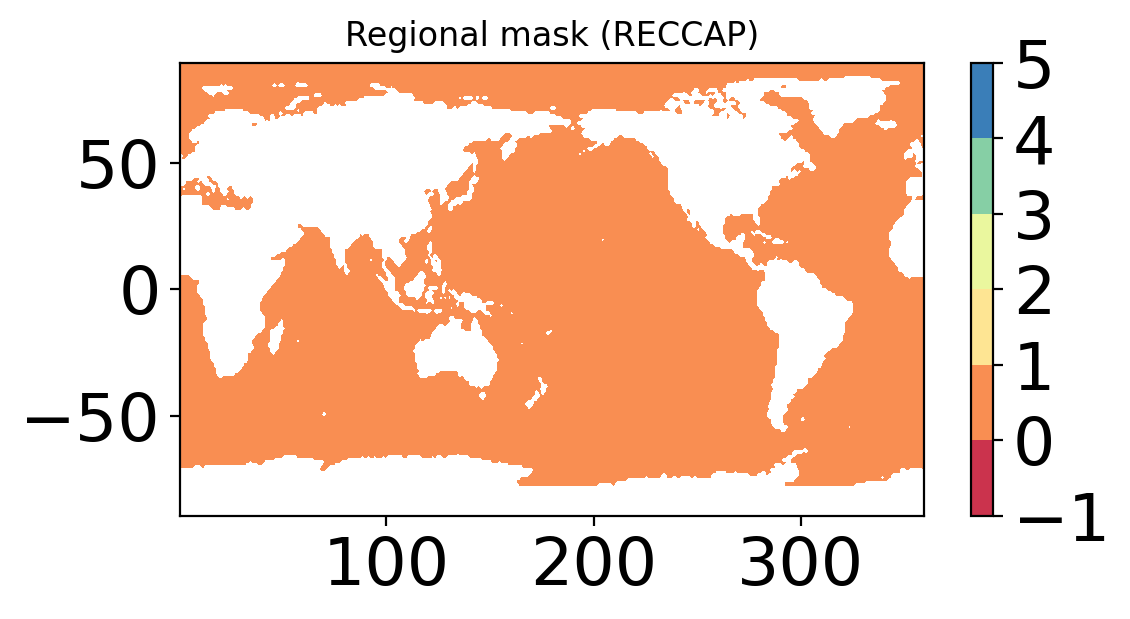

In [9]:
# take RECCAP mask

if mesh_id_src in ['fesom2_core_288']: # fesom2 GCB2022 runs
    path_mask = '/work/ollie/ncara/RECCAPv2/reccap2ocean_regions.nc'

fmask = Dataset(path_mask)
mask_global =  np.squeeze(fmask.variables['reccap2_ocean_regions'][:,:])

# define ocean mask (ocean=1.0, land=nan)
ind_land=mask_global*1.0 
ind_land[ind_land==0]=np.nan
ind_land[ind_land>0]=1.0

levels = np.arange(-1.,6., 1.)

dpicnt = 200
fig1= plt.figure(num=18, figsize=(6,3), dpi=dpicnt, facecolor='w', edgecolor='k')
#plt.contourf(X,Y,mask_global,cmap=cm.Spectral,levels = levels) #extend='both'
plt.contourf(X,Y,ind_land,cmap=cm.Spectral,levels = levels) #extend='both'

plt.title('Regional mask (RECCAP)')
cbar=plt.colorbar() #(im,"bottom", size="5%", pad=0.05)
#cbar.cmap.set_under('k')
plt.show(block=True)
#fig1.close()

In [10]:
# Generate masks
mask = pf.get_mask(mesh, "Global Ocean")
 
# something like this for N, S, T, see /home/ollie/jhauck/py_f2recom_from_laurent/pyfesom2/pyfesom2/ut.py

ind_N = np.where(mesh.y2 > 30)
mask_N = np.hstack((ind_N[0]))  #not sure why exactly this is needed, but then it seems to work...
ind_T = np.where((mesh.y2 <= 30) & (mesh.y2 >= -30))
mask_T = np.hstack((ind_T[0]))
ind_S = np.where(mesh.y2 <-30)
mask_S = np.hstack((ind_S[0]))

#flux_global = pf.areasum_data(data2, mesh, mask)
#flux_N = pf.areasum_data(data2, mesh, mask_N)
#flux_T = pf.areasum_data(data2, mesh, mask_T)
#flux_S = pf.areasum_data(data2, mesh, mask_S)

#flux_reg=np.zeros((records,3))
#flux_reg[:,0]=flux_N
#flux_reg[:,1]=flux_T
#flux_reg[:,2]=flux_S

#pf.plot(mesh,mask,ptype='pcm',levels=[0,0.5,1.0],cmap=cm.RdBu_r)

In [17]:
#------
# POST-PROCESS 2D FIELDS, priority 1
#------

#variable_list1_2D = ['fgco2','sfco2',\
#                     'fice',\
#                     'tos','sos',\
#                     'dissicos','talkos',\
#                     'intdic'] 

#------
# loop over simulations
#------
for ss in range(0,len(simulation_list_short)):
    simulation_id_short = simulation_list_short[ss]
    #print (simulation_id_short)
    
    #------
    # loop over variables
    #------
    for vv in variable_list1_2D:
        resultpath12 = resultpath+simulation_id_short+'/'
        
        var_id = vv
        ind_variable = variable_list1_2D.index(var_id)
        
        print ('Process variable '+var_id+' from simulation '+simulation_id_short+'...')
        
        #------
        # loop over years, post-process variables
        #------
# 2D
# --

        if var_id in ['fgco2']: # all CO2 flux related outputs
        
            fCO2fesom = pf.get_data(resultpath12, "CO2f", years, mesh, how="None", compute=True, runid='fesom', silent=True)
            # CO2f:description = "CO2-flux into the surface water" 
            # unit conversion: mmol C m-2 d-1 --> mol C m-2 s-1          
            data = fCO2fesom /(86400*1000)             
                       
        elif var_id in ['pCO2s']:
            data = pf.get_data(resultpath12, "pCO2s", years, mesh, how="None", compute=True, runid='fesom', silent=True)

        elif var_id in ['fice']:
            data = pf.get_data(resultpath12, "a_ice", years, mesh, how="None", compute=True, runid='fesom', silent=True)

        elif var_id in ['tos']:
            data = pf.get_data(resultpath12, "sst", years, mesh, how="None", compute=True, runid='fesom', silent=True)

        elif var_id in ['sos']:
            data = pf.get_data(resultpath12, "sss", years, mesh, how="None", compute=True, runid='fesom', silent=True)
# 3D
# --

        elif var_id in ['dissicos']:
            DIC      = pf.get_data(resultpath12, "DIC", years, mesh, how="None", compute=True, runid='fesom', silent=True)
            DICfesom = DIC[:,:,0]
            
            # unit conversion: mmol C m-3 --> mol C m-3
            data = DICfesom/1000
          
            del DIC,DICfesom
            
        elif var_id in ['talkos']:
            Alk      = pf.get_data(resultpath12, "Alk", years, mesh, how="None", compute=True, runid='fesom', silent=True)
            Alkfesom = Alk[:,:,0]
            
            # unit conversion: mmol C m-3 --> mol C m-3
            data = Alkfesom/1000    
            
            del Alk,Alkfesom
            
        elif var_id in ['intdic']:
            DIC      = pf.get_data(resultpath12, "DIC", years, mesh, how="None", compute=True, runid='fesom', silent=True)
            int_DIC=np.zeros((records,mesh.n2d))
            a1=np.zeros((mesh.n2d,mesh.nlev-1))
            for nn in range(0,records):
                a1 = DIC[nn,:,:]
                int_DIC[nn,:]=np.sum(a1*delta_z,axis=1)
                
            # unit conversion: mmol --> mol
            data = int_DIC* 1e-3
            
            del DIC,a1
            
        elif var_id in ['sfco2']:
            # SST (sea surface temperature, deg C):
            sstfesom = pf.get_data(resultpath12, "sst", years, mesh, how="None", compute=True, runid='fesom', silent=True)

            # surface pCO2 (partial pressure of CO2):
            #--> later to be converted to fCO2, fugacity of CO2 (real gas, not ideal)
            pCO2fesom = pf.get_data(resultpath12, "pCO2s", years, mesh, how="None", compute=True, runid='fesom', silent=True)

            # CO2 flux:
            #CO2ffesom = pf.get_data(resultpath12, "CO2f", years, mesh, how="None", compute=True, runid='fesom', silent=True)    

            
            # convert pCO2 to fCO2

            # using mocsy code
            # from https://github.com/jamesorr/mocsy/blob/master/src/varsolver.f90
            # line 220 to 236

            tk0 = 273.15 + sstfesom  # K
            Ptot=1                   # atm

            # Now that we have T and P in the right form, continue with calculation of fugacity coefficient (and pCO2)
            Rgas_atm = 82.05736      # (cm3 * atm) / (mol * K)  CODATA (2006)
            #To compute fugcoeff, we need 3 other terms (B, Del, xc2) in addition to 3 others above (tk, Ptot, Rgas_atm)
            B = -1636.75 + 12.0408*tk0 - 0.0327957*(tk0*tk0) + 0.0000316528*(tk0*tk0*tk0)
            Del = 57.7 - 0.118*tk0
            # "x2" term often neglected (assumed = 1) in applications of Weiss's (1974) equation 9
            #! x2 = 1 - x1 = 1 - xCO2 (it is very close to 1, but not quite)
            #! Let's assume that xCO2 = fCO2. Resulting fugcoeff is identical to 8th digit after the decimal.
            xCO2approx = pCO2fesom * 1.e-6
            #  IF (trim(opGAS) == 'Pinsitu' .OR. trim(opGAS) == 'pinsitu') THEN
            #!    xCO2approx = 400.0e-6_r8      !a simple test (gives about same result as seacarb for pCO2insitu)
            #!    approximate surface xCO2 ~ surface fCO2 (i.e., in situ fCO2 d by exponential pressure correction)
            xCO2approx = xCO2approx * np.exp(((1-Ptot)*32.3)/(82.05736*tk0)) #  ! of K0 press. correction, see Weiss (1974, equation 5)
            #  ENDIF
            xc2 = (1.0 - xCO2approx)**2 
            fugcoeff = np.exp(Ptot*(B + 2.0*xc2*Del)/(Rgas_atm*tk0))
            #  pCO2 = fCO2 / fugcoeff
            #####fCO2fesom = pCO2fesom * fugcoeff
            data = pCO2fesom * fugcoeff
            
            del sstfesom,pCO2fesom
    
        data_reg=np.zeros((records,len(Y),len(X)))

        cnt=0                                     
        for i in range(records):                   
            data_to_regrid = np.squeeze(data[i,:])  
            data_integrated_interp = griddata((mesh.x2, mesh.y2),data_to_regrid.ravel(),\
                        (X360_transf.ravel(), Y180_transf.ravel()), method='linear')  # Final interpolated field
            test = data_integrated_interp.reshape((X360_transf.shape[0],X360_transf.shape[1])) 
            test = transform_lon_coord(test)
            data_reg[cnt,:,:]=test*ind_land

            cnt=cnt+1
        del data_integrated_interp,test
        
# fill land with fill value for 2D/3D fields
        fill_value = -9999.
        #data_reg[ind_land_time]=fill_value
        save_regridded_as_netcdf_2D(simulation_id_short,var_id,model_id,grid_id,\
                            time_range,X,Y,reccap_time,data_reg,\
                                units_list1_2D[ind_variable],descr_list1_2D[ind_variable],fill_value,save_dir)     
        del data_reg,fill_value,ind_variable,var_id

Process variable pCO2s from simulation A...
('time', 'nod2')
False
False
True
Create file /work/ollie/ogurses/GCB2022/test//pCO2s_FESOM2_REcoM_A_1_gr_2020-2021_v20220716.nc
Process variable pCO2s from simulation B...
('time', 'nod2')
False
False
True
Create file /work/ollie/ogurses/GCB2022/test//pCO2s_FESOM2_REcoM_B_1_gr_2020-2021_v20220716.nc
Process variable pCO2s from simulation C...
('time', 'nod2')
False
False
True
Create file /work/ollie/ogurses/GCB2022/test//pCO2s_FESOM2_REcoM_C_1_gr_2020-2021_v20220716.nc
Process variable pCO2s from simulation D...
('time', 'nod2')
False
False
True
Create file /work/ollie/ogurses/GCB2022/test//pCO2s_FESOM2_REcoM_D_1_gr_2020-2021_v20220716.nc


In [18]:
var_id               = 'mask_sfc' # variable_id will be defined in loop
# corresponding units (according to RECCAP protocol; model output is converted where necessary)
unit_var_id          = 'n.d.'
description_var_id   = 'Field indicating the fraction of presence of ocean in a grid cell [0-1]; fraction of surface area'

# define mask
data_reg = ind_land

# NaN -> 0.0
np.nan_to_num(data_reg)

masked_array(
  data=[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],
  mask=False,
  fill_value=1e+20)

In [ ]:
# Ancillary part
# PLEASE RUN for EACH VARIABLE separately

In [20]:
var_id               = 'area' # variable_id will be defined in loop
# corresponding units (according to RECCAP protocol; model output is converted where necessary)
unit_var_id          = 'm2'
description_var_id   = 'Total surface area of each grid cell (regridded)'

# Surface area
data_reg=np.zeros((len(Y),len(X)))
                  
data_to_regrid = nod_area[:,0]  
data_integrated_interp = griddata((mesh.x2, mesh.y2),data_to_regrid.ravel(),\
          (X360_transf.ravel(), Y180_transf.ravel()), method='linear')  # Final interpolated field
test = data_integrated_interp.reshape((X360_transf.shape[0],X360_transf.shape[1])) 
test = transform_lon_coord(test)
data_reg[:,:]=test*ind_land

del data_integrated_interp,test

In [ ]:
var_id               = 'volume' # variable_id will be defined in loop
# corresponding units (according to RECCAP protocol; model output is converted where necessary)
unit_var_id          = 'm3'
description_var_id   = 'Total volume of each grid cell (regridded)'

vol=np.empty_like(nod_area)

cnt=0
for i in range(mesh.nlev-1):
    a1=0.5*(nod_area[:,i]+nod_area[:,i+1])*delta_z[i]
    vol[:,cnt]=a1
    #print (a1)
    cnt=cnt+1
    
vol_fesom=vol[:,:-1]

# Interpolate volume
data_reg=np.zeros((mesh.nlev-1,len(Y),len(X)))

cnt=0                                     
for i in range(mesh.nlev-1):
    data_to_regrid = vol_fesom[:,i]  
    data_integrated_interp = griddata((mesh.x2, mesh.y2),data_to_regrid.ravel(),\
              (X360_transf.ravel(), Y180_transf.ravel()), method='linear')  # Final interpolated field
    test = data_integrated_interp.reshape((X360_transf.shape[0],X360_transf.shape[1])) 
    test = transform_lon_coord(test)
    data_reg[i,:,:]=test*ind_land
    cnt=cnt+1

In [ ]:
var_id               = 'mask_vol' # variable_id will be defined in loop
# corresponding units (according to RECCAP protocol; model output is converted where necessary)
unit_var_id          = 'n.d.'
description_var_id   = 'Field indicating the fraction of presence of ocean in a grid cell [0-1]; fraction of volume'

vol=np.empty_like(nod_area)

cnt=0
for i in range(mesh.nlev-1):
    a1=0.5*(nod_area[:,i]+nod_area[:,i+1])*delta_z[i]
    vol[:,cnt]=a1
    #print (a1)
    cnt=cnt+1
    
vol_fesom=vol[:,:-1]

mask_vol=np.empty_like(vol_fesom)

mask_vol[vol_fesom>0] = 1
#print(mask_vol.min())
#mask_vol.shape


# Interpolate volume
data_reg=np.zeros((mesh.nlev-1,len(lat),len(lon)))

cnt=0                                     
for i in range(mesh.nlev-1):
    data_to_regrid = mask_vol[:,i]  
    data_integrated_interp = griddata((mesh.x2, mesh.y2),data_to_regrid.ravel(),\
              (X360_transf.ravel(), Y180_transf.ravel()), method='linear')  # Final interpolated field
    test = data_integrated_interp.reshape((X360_transf.shape[0],X360_transf.shape[1])) 
    test = transform_lon_coord(test)
    data_reg[i,:,:]=test*ind_land
    cnt=cnt+1

In [ ]:
#Save surface mask (Taken from RECCAPv2)

save_to_dir = save_dir+'/'
if not os.path.exists(save_to_dir):
    print ('Created '+save_to_dir)
    os.makedirs(save_to_dir)
netcdf_name = var_id+'_'+model_id+'_'+grid_id+vers+'.nc'
desc=model_id+' GCB '+var_id
if not os.path.exists(save_to_dir+netcdf_name):
    print ('Create file '+save_to_dir+netcdf_name)
    w_nc_fid = Dataset(save_to_dir+netcdf_name, 'w', format='NETCDF4_CLASSIC')  
        
    w_nc_fid.description = desc
    w_nc_fid.institution = "AWI/Marine BioGeoSciences"
    w_nc_fid.contact = "judith.hauck@awi.de, ozgur.gurses@awi.de"
    w_nc_fid.history     = 'Created ' + time.ctime(time.time())
        
    # create dimension & variable
    w_nc_fid.createDimension('Lon', len(X))  # lon in regular mesh
    w_nc_fid.createDimension('Lat', len(Y))  # lat in regular mesh
    if var_id in ['volume']:
        w_nc_fid.createDimension('Lay', mesh.nlev-1)  # lat in regular mesh
    elif var_id in ['mask_vol']:
        w_nc_fid.createDimension('Lay', mesh.nlev-1)  # lat in regular mesh
        
    w_nc_var1 = w_nc_fid.createVariable('Lon', 'f8',('Lon'))
    w_nc_var2 = w_nc_fid.createVariable('Lat', 'f8',('Lat'))
    if var_id in ['volume']:
        w_nc_var3 = w_nc_fid.createVariable('Layer', 'f8',('Lay'))
    elif var_id in ['mask_vol']:
        w_nc_var3 = w_nc_fid.createVariable('Layer', 'f8',('Lay'))

    w_nc_var1.unit = 'degrees E'
    w_nc_var2.unit = 'degrees N'
    if var_id in ['volume']:
        w_nc_var3.unit = 'layer'
    elif var_id in ['mask_vol']:
        w_nc_var3.unit = 'layer'
              
    # write
    w_nc_fid.variables['Lon'][:] = X
    w_nc_fid.variables['Lat'][:] = Y
    if var_id in ['volume']:    
        w_nc_fid.variables['Layer'][:] = 1.0*np.arange(mesh.nlev-1)    
    elif var_id in ['mask_vol']:
        w_nc_fid.variables['Layer'][:] = 1.0*np.arange(mesh.nlev-1)    
    w_nc_fid.close()

else:
    print ('File '+save_to_dir+netcdf_name+' exists already, overwrite')

w_nc_fid = Dataset(save_to_dir+netcdf_name, 'r+', format='NETCDF4_CLASSIC')      # Create and open new netcdf file to write to
try:
    
    if var_id in ['volume']:    
        w_nc_var1 = w_nc_fid.createVariable(var_id, 'f8',('Lay','Lat','Lon'))
    elif var_id in ['mask_vol']:
        w_nc_var1 = w_nc_fid.createVariable(var_id, 'f8',('Lay','Lat','Lon'))     
    else:
        w_nc_var1 = w_nc_fid.createVariable(var_id, 'f8',('Lat','Lon'))
    w_nc_var1.unit = unit_var_id 
    w_nc_var1.description = description_var_id
except: 
    print ('File '+var_id+' exists already, overwrite')
    #data_reg = np.transpose(data_reg,(2,0,1))
    
if var_id in ['volume']:    
    w_nc_fid.variables[var_id][:,:,:] = data_reg
elif var_id in ['mask_vol']:
    w_nc_fid.variables[var_id][:,:,:] = data_reg
else:    
    w_nc_fid.variables[var_id][:,:] = data_reg
        
w_nc_fid.close()  